In [62]:
import matplotlib.pyplot as plt
from matrix_control import transposeMatrix, printMatrix, reshapeMatrix, sumMatrix
from layer import Neuron
# from model import LinearModel

In [63]:
train_image = []
sample_num = 84
for i in range(sample_num):
    image = plt.imread(fname='image/train/train{}.jpeg'.format(i+1))
    image = reshapeMatrix(image, 1, 256)[0]
    train_image.append(image)
train_image = transposeMatrix(train_image)

In [64]:
label = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# label = ['t']


In [65]:
input_size = 256
hidden_size_1 = 96
hidden_size_2 = 48
output_size = 7
learning_rate = 0.001
epochs = 50

In [66]:
from layer import Neuron, one_hot_encoding
from matrix_control import dimMatrix3to2, matrixDotProduct, multiplyScalar, printMatrix, reshapeMatrix, sumMatrix, transposeMatrix, splitMatrix, subtractMatrix, element_wise_multiply
from utils import ReLU, ReLU_derivatived, sigmoid, Softmax, cross_entropy, calAccuracy
import random


class LinearModel:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, sample_num, learning_rate, epochs):
        print("모델 생성 시작. 입력차원 {}개, 1히든차원 {}개, 2히든차원 {}개, 출력층 {}개로, 샘플 개수는 {}개 입니다."
              .format(input_size, hidden_size1, hidden_size2, output_size, sample_num));
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.sample_num = sample_num
        self.learning_rate = learning_rate
        self.epochs = epochs

        start = -1.0
        end = 1.0

        self.w1 = [[random.uniform(start, end) for _ in range(input_size)] for _ in range(hidden_size1)];
        self.w2 = [[random.uniform(start, end) for _ in range(hidden_size1)] for _ in range(hidden_size2)];
        self.w3 = [[random.uniform(start, end) for _ in range(hidden_size2)] for _ in range(output_size)];
        

    def preprocessing(self, X):
        for i in range(len(X)):
            for j in range(len(X[0])):
                X[i][j] = X[i][j] / 255.0
        
        return X


    def forward(self, X, label):
        labeled_list = one_hot_encoding(label=label)
        X = self.preprocessing(X)

        loss_val = []
        count_val = []
        for i in range(self.epochs): 
            print('epochs : {}'.format(i+1))
            dict = self.propagate(X)
            outputs = transposeMatrix(dict['a3'])

            if i%10 == 0:
                loss = 0
                for i in range(len(outputs)):
                    loss += cross_entropy(prob_dist_predicted=outputs[i], prob_dist_true=labeled_list[i])
                loss_val.append(loss)
                print(f'training loss : {loss}')

                count = calAccuracy(result=outputs, label=label)
                count_val.append(count)

            
            self.backpropagate(label=label, dict=dict)
        
        return loss_val, count_val


    def propagate(self, X):
        dict = {}

        z1 = matrixDotProduct(self.w1, X)
        a1 = ReLU(z1)
        # print(f'z1 = {z1}')
        # print(f'a1 = {a1}')

        z2 = matrixDotProduct(self.w2, a1)
        a2 = ReLU(z2)
        # print(f'z2 = {z2}')
        # print(f'a2 = {a2}')

        z3 = matrixDotProduct(self.w3, a2)
        a3 = sigmoid(z3)
        # print(f'z3 = {z3}')
        # print(f'a3 = {a3}')

        # a3 = Softmax(transposeMatrix(a3))

        dict = {
            'a0' : X,
            'z1' : z1,
            'a1' : a1,
            'z2' : z2,
            'a2' : a2,
            'z3' : z3,
            'a3' : a3
        }

        return dict


    def backpropagate(self, label, dict):
        labeled_list = one_hot_encoding(label=label)

        # dz, dw 구하기. chain rule
        dz_3 = transposeMatrix( subtractMatrix( matrix1=transposeMatrix(dict['a3']), matrix2=labeled_list ) )
        dw_3 = matrixDotProduct(dz_3, transposeMatrix(dict['a2']))
        da_2 = matrixDotProduct(transposeMatrix(self.w3), dz_3)

        dz_2 = element_wise_multiply( da_2, ReLU_derivatived( dict['z2'] ) )
        # dw_2 = multiplyScalar( matrixDotProduct ( dz_2, transposeMatrix(dict['a1']) ), 1/self.sample_num)
        dw_2 = matrixDotProduct( dz_2, transposeMatrix(dict['a1']) )
        da_1 = matrixDotProduct( transposeMatrix(self.w2), dz_2 )

        dz_1 = element_wise_multiply( da_1, ReLU_derivatived( dict['z1'] ) )
        # dw_1 = multiplyScalar( matrixDotProduct( dz_1, transposeMatrix(dict['a0']) ), 1/self.sample_num)
        dw_1 = matrixDotProduct( dz_1, transposeMatrix(dict['a0']) )
        da_0 = matrixDotProduct( transposeMatrix(self.w1), dz_1 )

        # 가중치 업데이트
        self.w1 = subtractMatrix(self.w1, multiplyScalar(matrix=dw_1, scalar=self.learning_rate))
        self.w2 = subtractMatrix(self.w2, multiplyScalar(matrix=dw_2, scalar=self.learning_rate))
        self.w3 = subtractMatrix(self.w3, multiplyScalar(matrix=dw_3, scalar=self.learning_rate))
    
    def test(self, test_data, test_label):
        # 테스트 데이터를 받아서 검증 작업을 실시한다.
        dict = self.propagate(X=test_data)

        return dict['a3']

In [67]:
model = LinearModel(input_size=input_size, hidden_size1=hidden_size_1, hidden_size2=hidden_size_2, output_size=output_size, sample_num=sample_num, learning_rate=learning_rate, epochs=epochs)
loss_val, count_val = model.forward(train_image, label)

모델 생성 시작. 입력차원 256개, 1히든차원 96개, 2히든차원 48개, 출력층 7개로, 샘플 개수는 84개 입니다.
epochs : 1
training loss : 470.3270097017538
정답 개수 : 13
epochs : 2
epochs : 3
epochs : 4
epochs : 5
epochs : 6
epochs : 7
epochs : 8
epochs : 9
epochs : 10
epochs : 11
training loss : 196.6695493331023
정답 개수 : 44
epochs : 12
epochs : 13
epochs : 14
epochs : 15
epochs : 16
epochs : 17
epochs : 18
epochs : 19
epochs : 20
epochs : 21
training loss : 87.37854190385265
정답 개수 : 69
epochs : 22
epochs : 23
epochs : 24
epochs : 25
epochs : 26
epochs : 27
epochs : 28
epochs : 29
epochs : 30
epochs : 31
training loss : 50.31965144801128
정답 개수 : 79
epochs : 32
epochs : 33
epochs : 34
epochs : 35
epochs : 36
epochs : 37
epochs : 38
epochs : 39
epochs : 40
epochs : 41
training loss : 33.600231166757524
정답 개수 : 82
epochs : 42
epochs : 43
epochs : 44
epochs : 45
epochs : 46
epochs : 47
epochs : 48
epochs : 49
epochs : 50


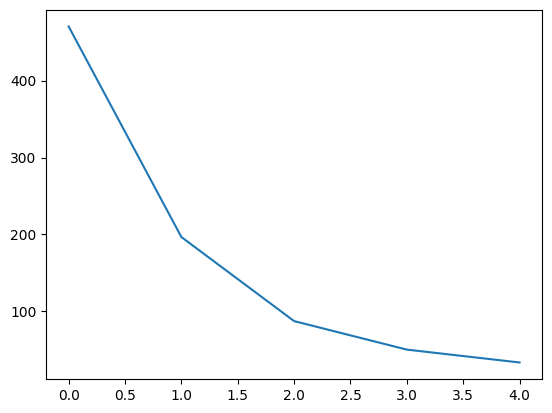

In [68]:
plt.plot(loss_val, label="loss")

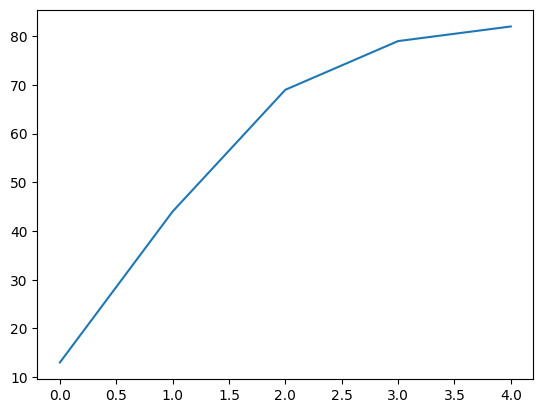

In [69]:
plt.plot(count_val, label="True count")

### Test

In [70]:
test_image = []
sample_num = 20
for i in range(sample_num):
    image = plt.imread(fname='image/train/train{}.jpeg'.format(i+1))
    image = reshapeMatrix(image, 1, 256)[0]
    test_image.append(image)
test_image = transposeMatrix(test_image)

test_label = ['t', 'u', 'v', 'w', 'x', 'y', 'z', 't', 'u', 'v', 'w', 'x', 'y', 'z',
         't', 'u', 'v', 'w', 'x', 'y']

test_result = model.test(test_data=test_image, test_label=test_label)

print(len(test_result))
print(len(test_result[0]))

7
20


In [71]:
calAccuracy(result=transposeMatrix(test_result), label=test_label)

정답 개수 : 20


20